#Projeto de Técnicas de Programação em Python - Manipulação de Imagens DATA Augmentation



O projeto é uma demonstração de data augmentation em imagens usando o TensorFlow e o TensorFlow Datasets. Ele carrega o conjunto de dados "oxford_iiit_pet", que contém imagens de gatos e cachorros, separando-os em conjuntos de treinamento e teste. O código define funções para converter as imagens em arrays NumPy, pré-processar os exemplos, filtrar por espécie (gato ou cachorro), exibir exemplos de imagens antes da aplicação de transformações e aplicar transformações como inversão e rotação nas imagens.


# Preparação do ambiente

### Importação das bibliotecas necessárias

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
!pip install tensorflow-datasets
import tensorflow as tf
from tensorflow import keras
from scipy import ndimage
from scipy.ndimage import rotate
from tensorflow_datasets import load
import cv2
import os


### Carregamento dos dados

In [ ]:
# Definindo a configuração de download para limitar o tamanho máximo
tfds.core.download.download_manager.DownloadConfig(manual_dir='/tmp/my_manual_data', max_examples_per_split=5)

# Carregamento dos dados
dataset_name = "oxford_iiit_pet"
ds_train = tfds.load(dataset_name, split='train', as_supervised=True)


### Conversão array numpy

In [ ]:
def image_to_numpy(image):
    with tf.compat.v1.Session() as sess:
        return sess.run(image)

###Mapeamento de rotulo

In [ ]:
def map_label(label):
    return "gato" if label == 0 else "cachorro"

###Pré processamento imagem e rótulo e converte para numpy

In [ ]:
def preprocess_example(example):
    example["especie"] = map_label(example["label"])
    del example["label"]
    # Converter a imagem para um array NumPy
    example["image"] = image_to_numpy(example["image"])
    return example

###Função para separar por especies

In [ ]:
def filter_by_species(species):
    def filter_fn(image, label):
        return label == species
    return filter_fn

###Função para plotar gatos e cachorros do dataset com sua respectiva legenda

In [ ]:
def display_examples(dataset, num_examples=5):
    for image, label in dataset.take(num_examples):
        plt.figure()
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title('Gato' if label.numpy() == 0 else 'Cachorro')
        plt.axis('off')
        plt.show()


In [ ]:
def mostrar_imagem(imagem, titulo=''):
    plt.title(titulo)
    plt.imshow(imagem)
    plt.show()


Exemplos de imagens de gatos do conjunto de treinamento :


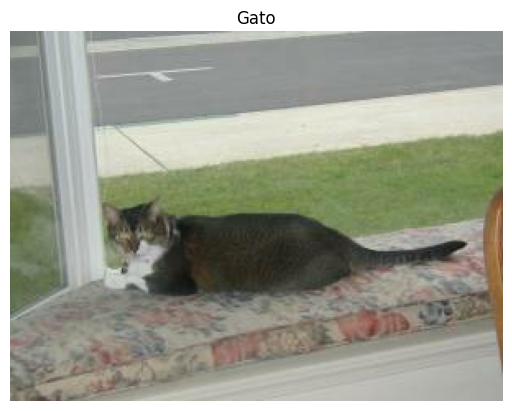

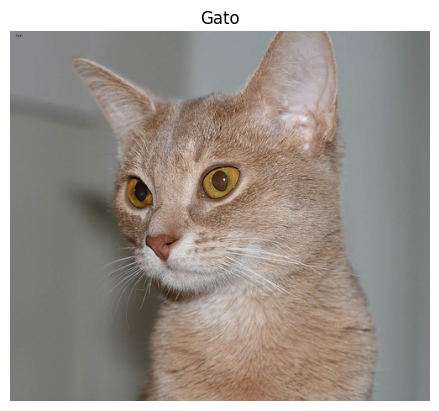

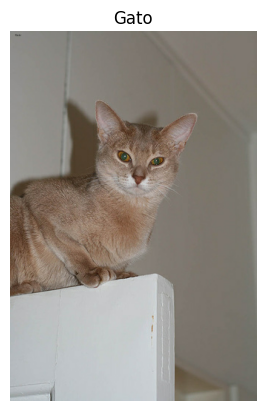

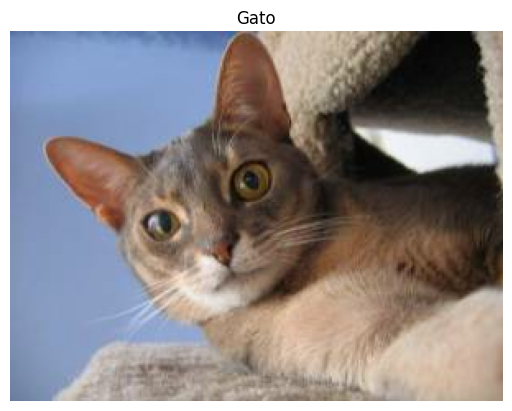

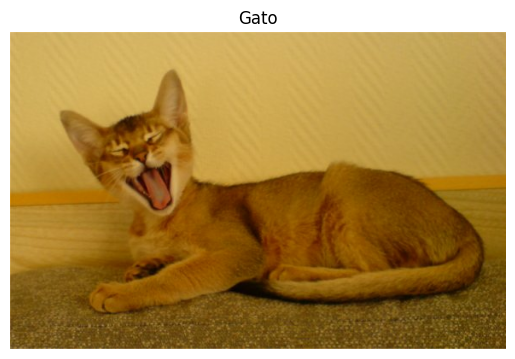

In [ ]:
print("\nExemplos de imagens de gatos do conjunto de treinamento :")
cat_images_train = ds_train.filter(filter_by_species(0))
display_examples(cat_images_train)


Exemplos de imagens de cachorros do conjunto de treinamento :


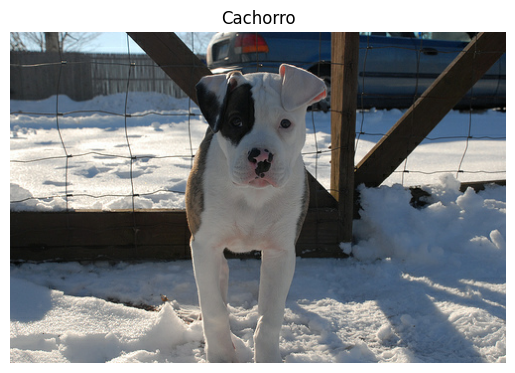

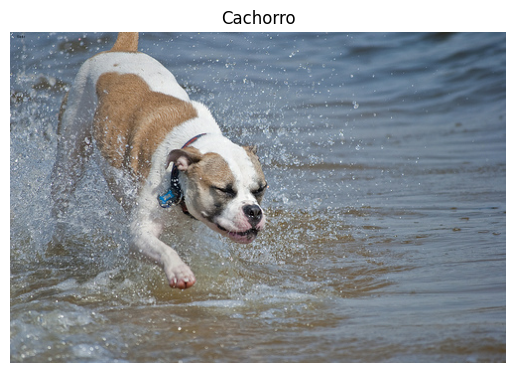

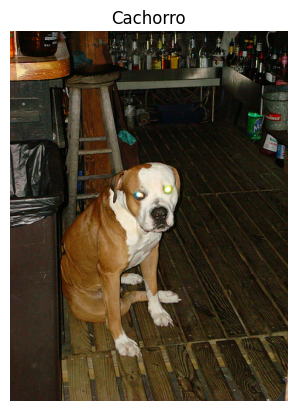

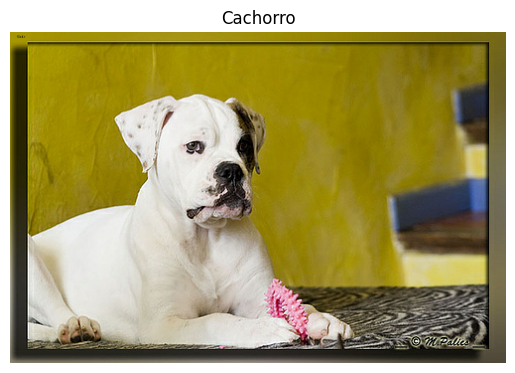

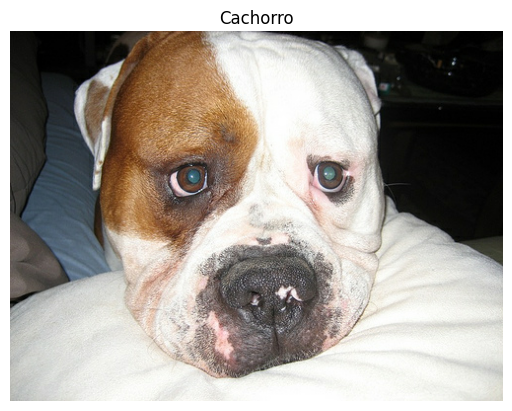

In [ ]:
print("\nExemplos de imagens de cachorros do conjunto de treinamento :")
dog_images_train = ds_train.filter(filter_by_species(1))
display_examples(dog_images_train)

#Data augmentation (Teste das técnicas)

####Nesta etapa itemos aplicar algumas técnicas de data augmentation

###Técnica 1 espelhamento

Nesta técnica buscamos espelhar a imagem em seu eixo horizontal

In [ ]:
def invert_image(image):
    if len(image.shape) < 2:
        raise ValueError("A imagem precisa ter pelo menos duas dimensões.")

    inverted_image = np.fliplr(image)

    return inverted_image

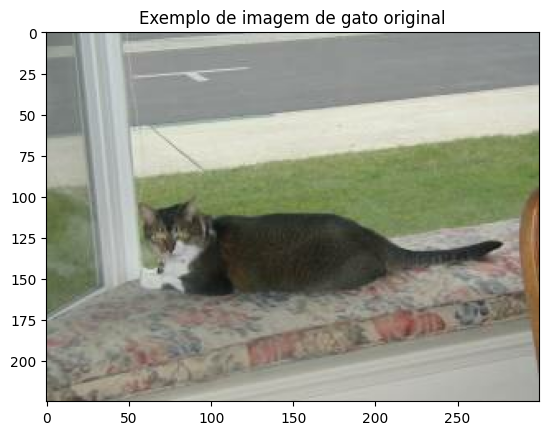

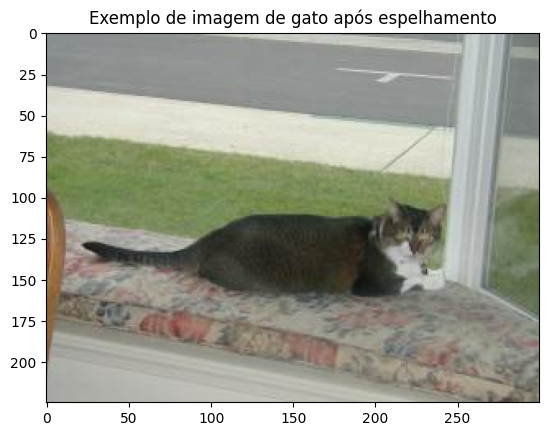

In [ ]:
example_image = next(iter(cat_images_train))[0]
mostrar_imagem(example_image, "Exemplo de imagem de gato original")
inverted_example_image = invert_image(example_image)
mostrar_imagem(inverted_example_image, "Exemplo de imagem de gato após espelhamento")

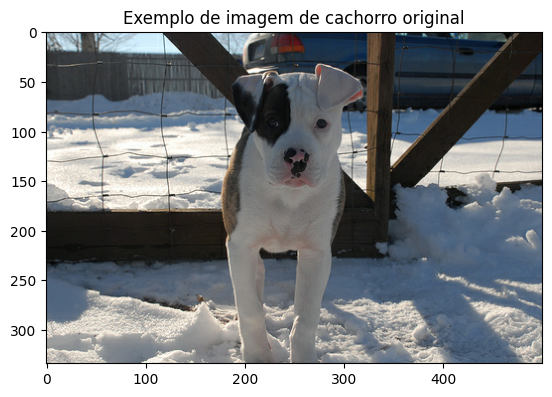

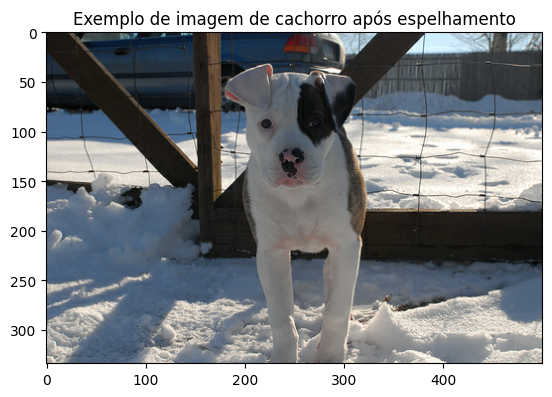

In [ ]:
example_image = next(iter(dog_images_train))[0]
mostrar_imagem(example_image, "Exemplo de imagem de cachorro original")
inverted_example_image = invert_image(example_image)
mostrar_imagem(inverted_example_image,"Exemplo de imagem de cachorro após espelhamento" )

###Técnica 2 (Rotação)

Esta técnica tem a função de rotacionar a imagem pelo ângulo especificado.

In [ ]:
def rotate_image(image, angle_degrees):
    rotated_image = rotate(image, angle_degrees, reshape=False)
    return rotated_image

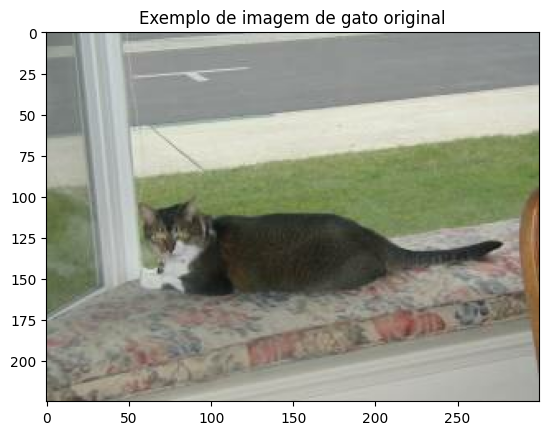

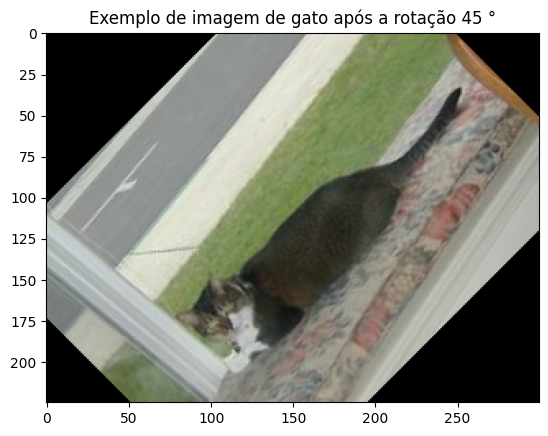

In [ ]:
#exemplo de imagem rotacionada
example_image = next(iter(cat_images_train))[0]
mostrar_imagem(example_image, "Exemplo de imagem de gato original")
rotated_example_image = rotate_image(example_image, 45)
mostrar_imagem(rotated_example_image,"Exemplo de imagem de gato após a rotação 45 °")


###Técnica 3 (mudança da intensidade da cor)

Essa técnica altera a cor da imagem multiplicando cada canal de cor pelo fator fornecido para modificar a intensidade de suas cores, onde se o fator for maior que 1, aumenta a intensidade da cor e se for menos que 1 reduz.




In [ ]:
def change_color(image, fator):
    colored_image = image * np.uint8(fator)
    return colored_image

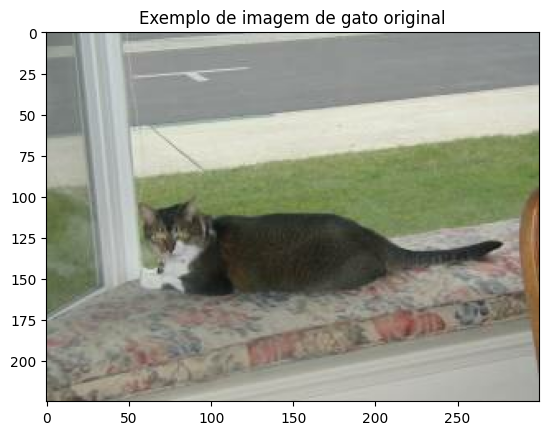

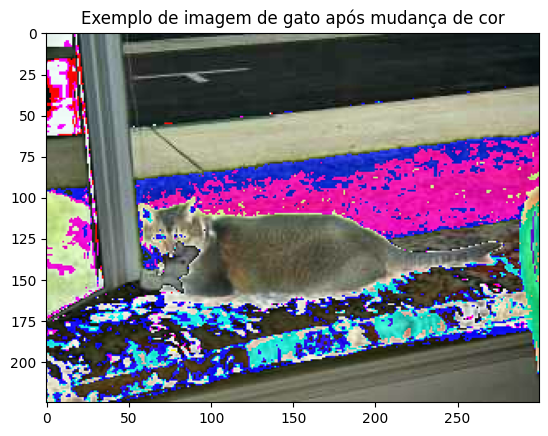

In [ ]:
#exemplo de imagem após mudança de cor
fator=2
example_image = next(iter(cat_images_train))[0]
mostrar_imagem(example_image, "Exemplo de imagem de gato original")
colored_example_image = change_color(example_image, fator=fator)
mostrar_imagem(colored_example_image, "Exemplo de imagem de gato após mudança de cor")


###Técnica 4 (deslocamento)

Essa técnica desloca a imagem ao longo dos eixos x e y podendo ser feitas de várias formas.

O primeiro exemplo foi utilizada a técnica para deslocar a imagem ao longo dos eixos x e y de forma circular

In [ ]:
#deslocamento imagem
def shift_image(image, shift_x, shift_y):
    shifted_image = np.roll(image, shift=(shift_x, shift_y), axis=(0, 1))
    return shifted_image

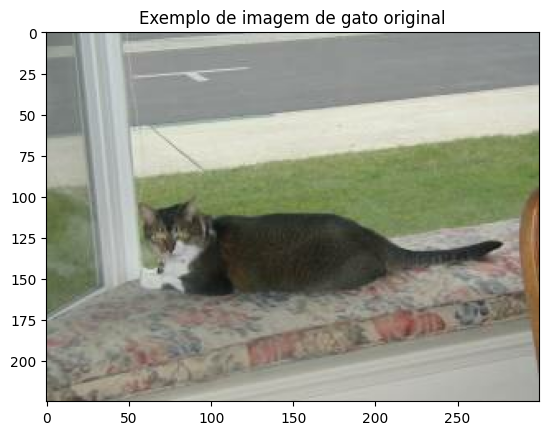

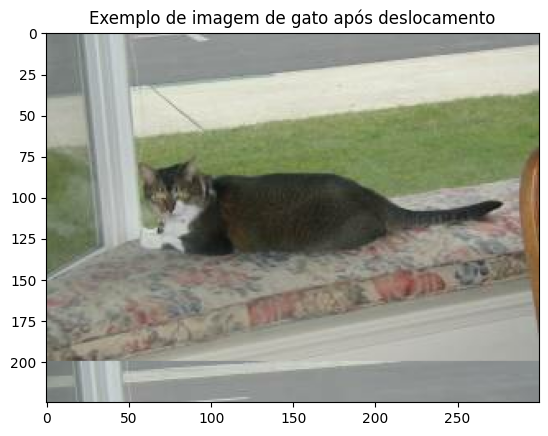

In [ ]:
example_image = next(iter(cat_images_train))[0]
mostrar_imagem(example_image, "Exemplo de imagem de gato original")
shifted_example = shift_image(example_image, shift_x=200, shift_y=0)
mostrar_imagem(shifted_example,"Exemplo de imagem de gato após deslocamento")


Segundo exemplo utilizamos para deslocr a imagem em uma quantidade específica ao longo dos eixos x e y, mantendo a dimensão original da imagem e preenchendo as áreas deslocadas com zeros.

In [ ]:
#Função deslocamento com corte
def shift(image, shift_amount):
    if len(image.shape) != 3:
        raise ValueError("A imagem deve ser 3D.")

    shifted_image = np.zeros_like(image)

    rows, cols, _ = image.shape
    row_shift, col_shift = shift_amount
    min_row = max(0, row_shift)
    max_row = min(rows, rows + row_shift)
    min_col = max(0, col_shift)
    max_col = min(cols, cols + col_shift)

    new_rows = max_row - min_row
    new_cols = max_col - min_col
    orig_rows = max_row - min_row
    orig_cols = max_col - min_col
    shifted_image[min_row:max_row, min_col:max_col, :] = image[:orig_rows, :orig_cols, :]

    return shifted_image

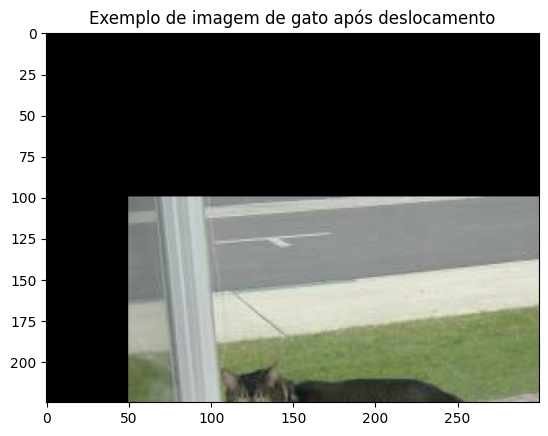

In [ ]:
shift_amount = (100, 50 )
example_image = next(iter(cat_images_train))[0]
shifted_example_image = shift(example_image, shift_amount)
mostrar_imagem(shifted_example_image, "Exemplo de imagem de gato após deslocamento")


E no terceiro exemplo utilizamos para deslocar a imagem em uma quantidade específica ao longo dos eixos x e y, mantendo a dimensão original da imagem e preenchendo as áreas deslocadas com a cor de fundo especificada, no nosso caso o branco.

In [ ]:
def shift_image_bg(image, shift_amount, background_color):
    shifted_image = np.ones_like(image) * background_color
    shift_rows, shift_cols = shift_amount
    start_row, end_row = max(0, shift_rows), min(image.shape[0] + shift_rows, shifted_image.shape[0])
    start_col, end_col = max(0, shift_cols), min(image.shape[1] + shift_cols, shifted_image.shape[1])
    shifted_image[start_row:end_row, start_col:end_col] = image[max(0, -shift_rows):min(image.shape[0], shifted_image.shape[0] - shift_rows),
                                                              max(0, -shift_cols):min(image.shape[1], shifted_image.shape[1] - shift_cols)]
    return shifted_image

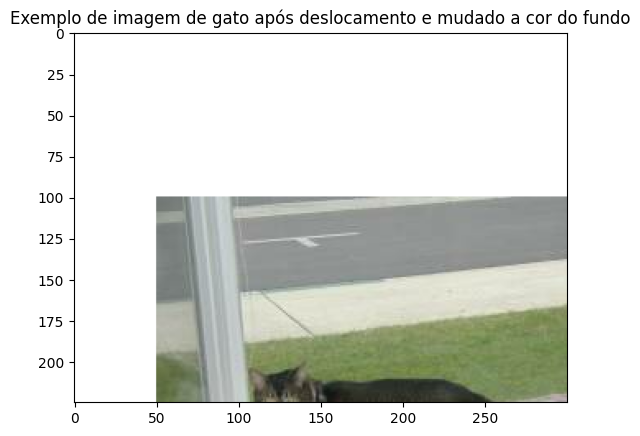

In [ ]:
shift_amount = (100, 50)
example_image = next(iter(cat_images_train))[0]
shifted_bg_example_image = shift_image_bg(example_image, shift_amount, 255)
mostrar_imagem(shifted_bg_example_image, "Exemplo de imagem de gato após deslocamento e mudado a cor do fundo")

###Técnica 5 (redimensionamento)

Essa técnica realiza um redimensionamento da imagem e pode ser utilizada de várias formas.
No nosso exemplo estamos realizando um redimensionamento da imagem no eixo y (altura) pelo fator size, mantendo as dimensões dos outros eixos inalteradas. Isso pode resultar em uma imagem esticada ou comprimida verticalmente, dependendo do valor de size

In [ ]:
def flatten_image(image, size):
    flattened_image = ndimage.zoom(image, (1, size, 1))
    return flattened_image

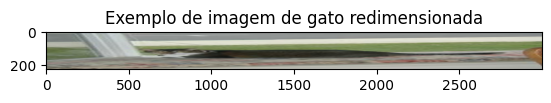

In [ ]:
example_image = next(iter(cat_images_train))[0]
flattened_example_image = flatten_image(example_image, 10)
mostrar_imagem(flattened_example_image, "Exemplo de imagem de gato redimensionada")

In [ ]:
# função para converter imagem para preto e branco
def convert_to_black_and_white(image):
     # Converter a imagem para escala de cinza
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar limiarização para converter em preto e branco
    _, black_and_white_image = cv2.threshold(grayscale_image, 127, 255, cv2.THRESH_BINARY)

    return black_and_white_image



A imagem está no formato BGR.


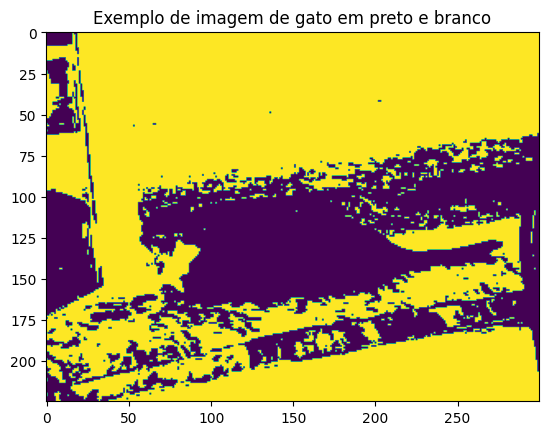

In [ ]:
example_image = next(iter(cat_images_train))[0]
if example_image[0, 0, 0] == example_image[0, 0, 2]:
    print("A imagem está no formato RGB.")
else:
    print("A imagem está no formato BGR.")

image_array = example_image.numpy()  # Convertendo o tensor para uma matriz numpy
c_b_w = convert_to_black_and_white(image_array)
mostrar_imagem(c_b_w, "Exemplo de imagem de gato em preto e branco")

###Aplicando mais de uma técnica na mesma imagem

In [ ]:
def apply_all_modifications_combined(image, angle, fator):
    inverted_image = invert_image(image)
    rotated_image = rotate_image(inverted_image, angle)
    colored_image = change_color(rotated_image, fator)
    return colored_image

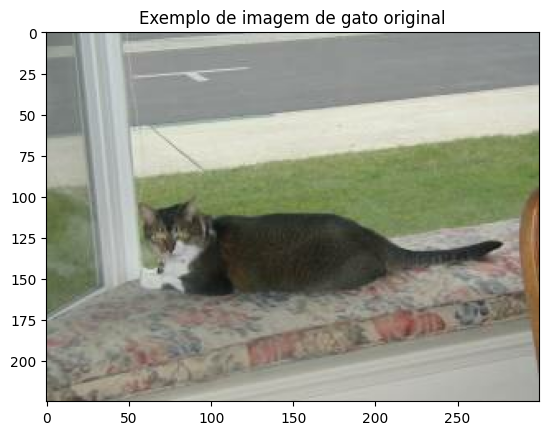

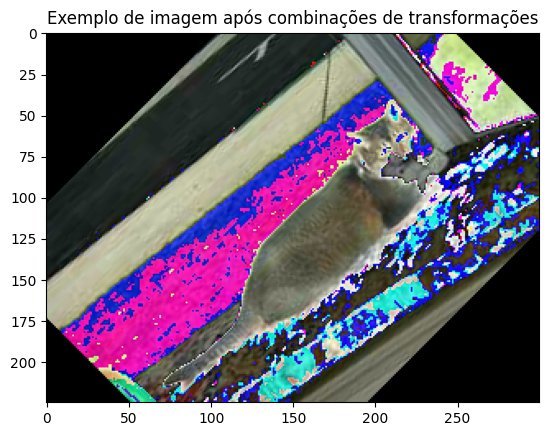

In [ ]:
example_image = next(iter(cat_images_train))[0]
mostrar_imagem(example_image, "Exemplo de imagem de gato original")
combined_image = apply_all_modifications_combined(example_image, 45, 2)
mostrar_imagem(combined_image, "Exemplo de imagem após combinações de transformações")

###Salvando imagens do dataset no diretorio

In [ ]:
def save_images_to_directory(dataset, num_images, directory):
    # Certifique-se de que o diretório exista ou crie-o se não existir
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Salvar as imagens no diretório especificado
    for i, (image, label) in enumerate(dataset.take(num_images)):
        filename = f"{directory}/image_{i}_{label.numpy()}.jpg"
        image_np = image.numpy()
        cv2.imwrite(filename, image_np)
        print(f"Imagem salva como {filename}")

# Chamada da função para salvar as imagens
save_images_to_directory(cat_images_train, 5, "cat_images")


Imagem salva como cat_images/image_0_0.jpg
Imagem salva como cat_images/image_1_0.jpg
Imagem salva como cat_images/image_2_0.jpg
Imagem salva como cat_images/image_3_0.jpg
Imagem salva como cat_images/image_4_0.jpg


###Lendo imagens salvas

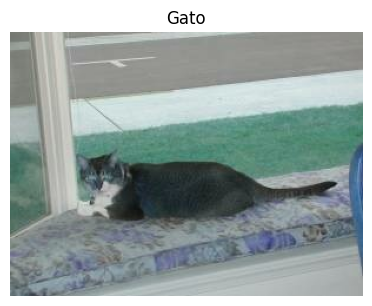

In [ ]:
def read_images_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image = cv2.imread(os.path.join(directory, filename))
            # OpenCV lê as imagens em formato BGR, então precisamos convertê-las para RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            labels.append(int(filename.split("_")[2].split(".")[0]))  # Extrai o rótulo do nome do arquivo
    return images, labels

# Leitura das imagens de gatos
cat_images, cat_labels = read_images_from_directory("cat_images")

# Exibição de uma imagem de cada categoria
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_images[0])
plt.title("Gato")
plt.axis('off')


plt.show()

In [ ]:
def save_image(image, label, directory):
    # Salvar a imagem em disco
    filename = f'image_label_{label}.jpg'
    cv2.imwrite(os.path.join(directory, filename), image)
    print(f"Imagem salva como {filename} em {directory}.")

##Aplicando Data augmentation nas imagens salvas e salvando a atualização

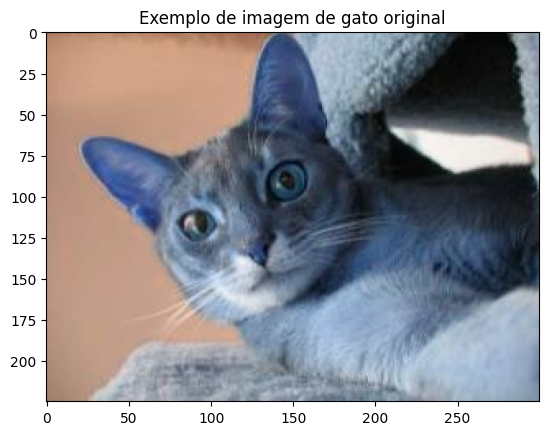

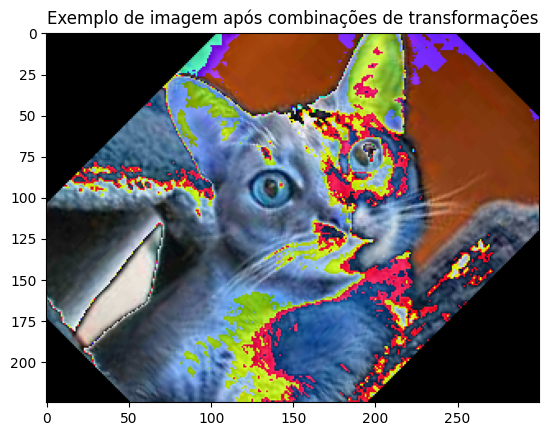

Imagem salva como image_label_1.jpg em cat_images.


In [ ]:
example_image = cat_images[1]
mostrar_imagem(example_image, "Exemplo de imagem de gato original")
combined_image = apply_all_modifications_combined(example_image, 45, 2)
mostrar_imagem(combined_image, "Exemplo de imagem após combinações de transformações")
save_image(combined_image, 1, "cat_images")

